# Executive Summary <br>
- Land and ocean temperature was modeled
- Temperature began increasing trend at around 1920-1980
- Holt's model was most effective at modeling temperature

# Plan <br>
- Analysis procedure follows the standard data science pipeline
- Obtain data from link in csv format, copy to working directory
- Assume ocean is a heatsink that changes temperature less easily than air, and thus less susceptible to short-term effects
- Compare land and ocean temps over time
- Start at 1900, so we have better quality data (global temp measurments are relatively new to the world)
- NASA website states that accurate global temperature measurements began at around 1880

In [139]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
# Data taken from the link below:
# https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

# Get temp data on countries
country_df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
country_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [3]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


In [4]:
# Find out how many countries we have
country_df.Country.nunique()

243

In [5]:
country_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,544811.0,17.193354,10.953966,-37.658,10.025,20.901,25.814,38.842
AverageTemperatureUncertainty,545550.0,1.019057,1.201930,0.052,0.323,0.571,1.206,15.003


In [6]:
# get global temp data
global_df = pd.read_csv('GlobalTemperatures.csv')
global_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [8]:
global_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LandAverageTemperature,3180.0,8.374731,4.381310,-2.080,4.31200,8.6105,12.54825,19.021
LandAverageTemperatureUncertainty,3180.0,0.938468,1.096440,0.034,0.18675,0.3920,1.41925,7.880
LandMaxTemperature,1992.0,14.350601,4.309579,5.900,10.21200,14.7600,18.45150,21.320
LandMaxTemperatureUncertainty,1992.0,0.479782,0.583203,0.044,0.14200,0.2520,0.53900,4.373
LandMinTemperature,1992.0,2.743595,4.155835,-5.407,-1.33450,2.9495,6.77875,9.715
LandMinTemperatureUncertainty,1992.0,0.431849,0.445838,0.045,0.15500,0.2790,0.45825,3.498
LandAndOceanAverageTemperature,1992.0,15.212566,1.274093,12.475,14.04700,15.2510,16.39625,17.611
LandAndOceanAverageTemperatureUncertainty,1992.0,0.128532,0.073587,0.042,0.06300,0.1220,0.15100,0.457


Takeaways from Acquire: <br>
- dt column is not in date-time type, temp data is float, country data is string
- Numeric temp columns have many nulls
- Country min temp of -37 and max temp of 38 ( 8 and 19 respectively for globe)
- Temp is in degree celcius given the range (38C is 100F, still seems low for max)
- Temp was measured in 243 countries
- Begins in 1743, before accurate temperate measurements were common

# Prepare

In [9]:
# Assume that we did not have accurate global temperature measurements until 1880
# Assumption comes from:
# https://earthobservatory.nasa.gov/world-of-change/global-temperatures

def prepare_temp_data(df):
    # dt column name may cause problems because 'dt' is used to call some methods
    # rename dt column to date
    # give shorter names to other columns too
    df.rename(columns={'dt':'date','LandAverageTemperature':'land_avg','LandAverageTemperatureUncertainty':'land_unc','LandMaxTemperature':'land_max', 'LandMaxTemperatureUncertainty':'land_max_unc', 'LandMinTemperature':'land_min', 'LandMinTemperatureUncertainty':'land_min_unc', 'LandAndOceanAverageTemperature':'land_ocean_avg', 'LandAndOceanAverageTemperatureUncertainty':'land_ocean_unc'}, inplace=True)
    
    # set the date to datetime type
    df.date = pd.to_datetime(df.date)
    
    # add columns for year and date
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    
    # set index to date
    df = df.set_index('date').sort_index()
    
    # good global temp measurements supposedly began in 1880 (according to NASA website)
    # use 1900 as starting point to improve data integrity and quality
    df = df[df.year >= 1900]
    
    # group by year and aggregate by mean
    # if I resample by less than year, then data so smushed together that I can't see much
    # We are not looking for short or seasonal changes, but lasting global trends
    df = df.resample('Y').mean()
    
    return df

global_df = prepare_temp_data(global_df)
global_df.head()

,land_avg,land_unc,land_max,land_max_unc,land_min,land_min_unc,land_ocean_avg,land_ocean_unc,year,month
date,,,,,,,,,,
1900-12-31,8.501583,0.314750,14.389500,0.387583,2.575667,0.406250,15.143917,0.150250,1900.0,6.5
1901-12-31,8.541917,0.306250,14.512167,0.448167,2.490500,0.397500,15.073333,0.145750,1901.0,6.5
1902-12-31,8.304417,0.292750,14.364250,0.394333,2.203750,0.356167,14.958333,0.135500,1902.0,6.5
1903-12-31,8.220167,0.290000,14.085750,0.389750,2.283333,0.378250,14.836583,0.134833,1903.0,6.5
1904-12-31,8.090917,0.286417,14.063667,0.500000,2.171083,0.337750,14.810417,0.133083,1904.0,6.5


In [10]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 1900-12-31 to 2015-12-31
Freq: A-DEC
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   land_avg        116 non-null    float64
 1   land_unc        116 non-null    float64
 2   land_max        116 non-null    float64
 3   land_max_unc    116 non-null    float64
 4   land_min        116 non-null    float64
 5   land_min_unc    116 non-null    float64
 6   land_ocean_avg  116 non-null    float64
 7   land_ocean_unc  116 non-null    float64
 8   year            116 non-null    float64
 9   month           116 non-null    float64
dtypes: float64(10)
memory usage: 10.0 KB


In [11]:
# no nulls after data prep
global_df.isna().sum()

land_avg          0
land_unc          0
land_max          0
land_max_unc      0
land_min          0
land_min_unc      0
land_ocean_avg    0
land_ocean_unc    0
year              0
month             0
dtype: int64

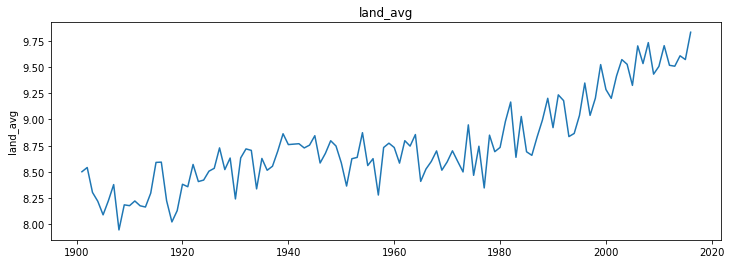

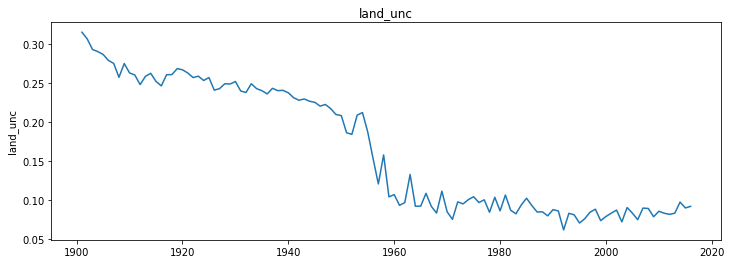

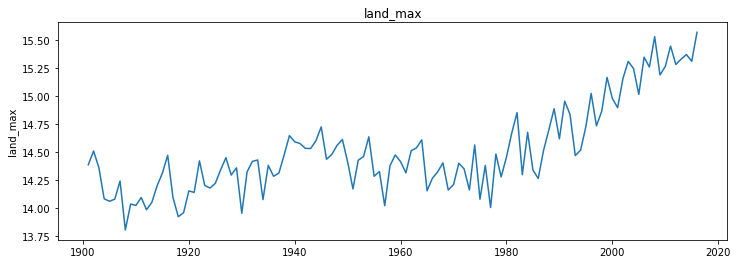

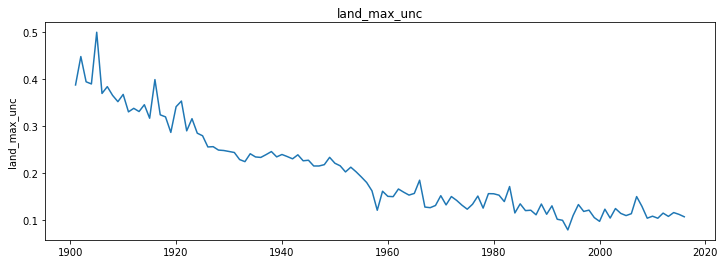

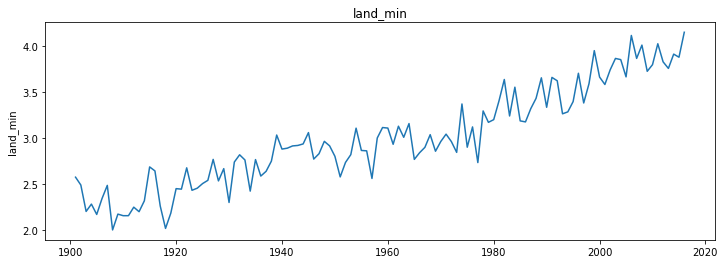

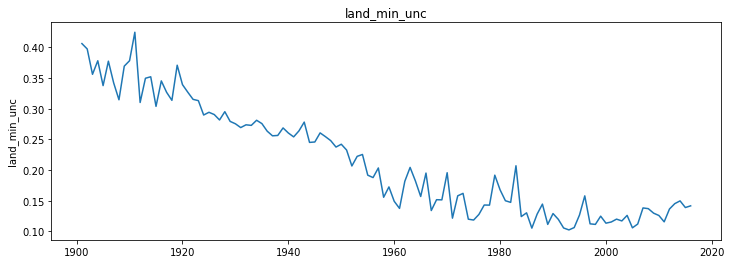

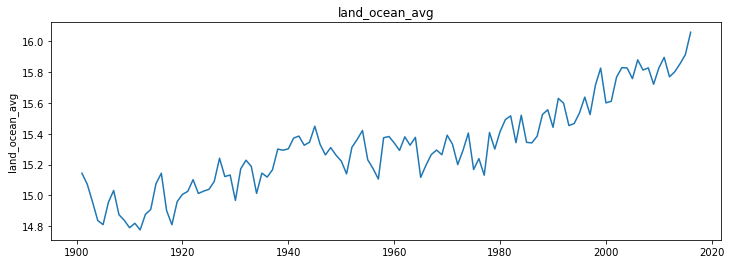

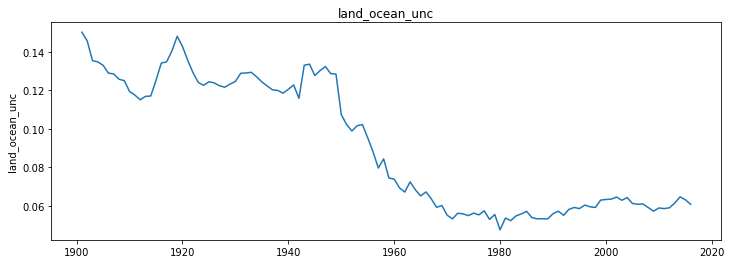

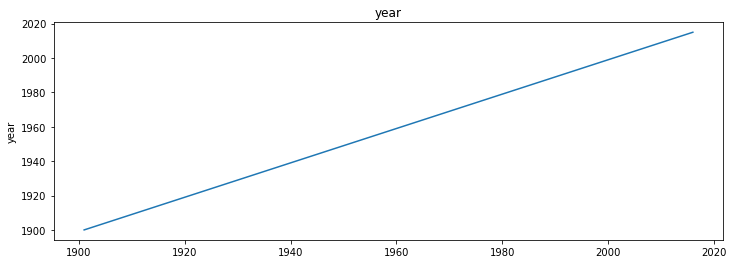

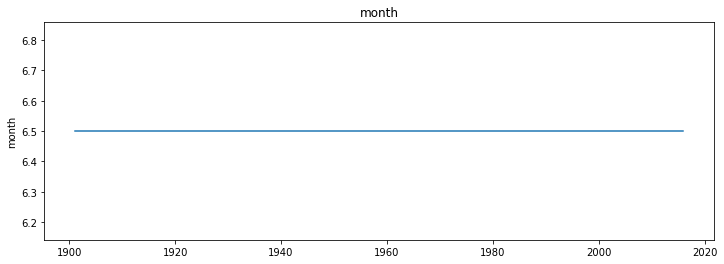

In [12]:
# take a look at the data
for col in global_df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(global_df[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [13]:
def check_gaps():
    df = pd.read_csv('GlobalTemperatures.csv')
    df.rename(columns={'dt':'date'}, inplace=True)
    df.date = pd.to_datetime(df.date)
    df['year'] = df.date.dt.year
    df = df.set_index('date').sort_index()
    df = df[df.year >= 1900]
    index_days = df.index.nunique()
    n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
    
    print('Number of rows: ', index_days)
    print('Number of days between first and last day: ', n_days)
    
check_gaps()

Number of rows:  1392
Number of days between first and last day:  42338 days 00:00:00


In [14]:
print('Years determined by min and max date: ', 42338/365)

Years determined by min and max date:  115.9945205479452


In [15]:
print('Years determined by unique rows on index: ', 1392/365)

Years determined by unique rows on index:  3.813698630136986


Takeaways for Prepare: <br>
- No nulls, but many gaps in time
- Slight increase in temp starting ~1920 and accelerating ~1980
- Uncertainty decreases over time, lowest trend at ~1960 to ~1980

# Explore

In [16]:
# I am going to narrow my focus to just land_ocean_avg
# the ocean is a heatsink, so it may be more resistant to short-term temperature changes
global_df = pd.DataFrame(global_df.land_ocean_avg)
global_df.head()

,land_ocean_avg
date,
1900-12-31,15.143917
1901-12-31,15.073333
1902-12-31,14.958333
1903-12-31,14.836583
1904-12-31,14.810417


In [17]:
# split the data
train_size = int(len(global_df) * 0.5)
validate_size = int(len(global_df) * 0.3)
test_size = int(len(global_df)) - train_size - validate_size
validate_end_index = train_size + validate_size
train = global_df[:train_size]
validate = global_df[train_size:validate_end_index]
test = global_df[validate_end_index:]

In [18]:
# verify the splits in the data
# sum of split groups is equal to df
print(len(train) + len(validate) + len(test) == len(global_df))

True


In [19]:
# first row of df is equal to first row of train
print(global_df.head(1) == train.head(1))

            land_ocean_avg
date                      
1900-12-31            True


In [20]:
# end of train is adjacent to beginning of validate
pd.concat([train.tail(1), validate.head(1)])

,land_ocean_avg
date,
1957-12-31,15.374083
1958-12-31,15.382083


In [21]:
# end of validate is adjacent to beginning of test
pd.concat([validate.tail(1), test.head(1)])

,land_ocean_avg
date,
1991-12-31,15.598
1992-12-31,15.453


In [22]:
# end of test is equal to end of df
print(test.tail(1) == global_df.tail(1))

            land_ocean_avg
date                      
2015-12-31            True


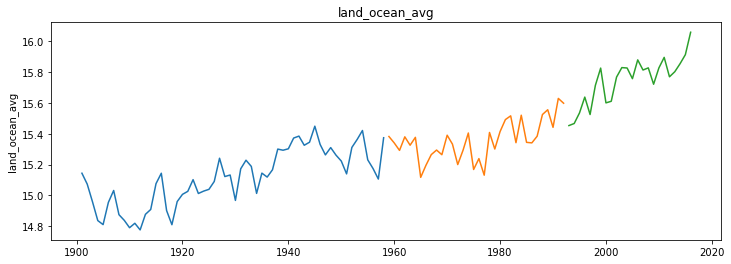

In [23]:
for col in train.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Model

In [24]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [25]:
# plot and evaluate
def plot_and_eval(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE : {:.0f}'.format(rmse))
    plt.show()
    

In [26]:
# create a df of evaluation metrics

# create the empty df
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type':[model_type], 'target_var':[target_var], 'rmse':[rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

Last Observed Value Model

In [27]:
# create a baseline value based on last value
loa = train['land_ocean_avg'][-1:][0]

yhat_df = pd.DataFrame({'land_ocean_avg':[loa]}, index = validate.index)
yhat_df.head()

,land_ocean_avg
date,
1958-12-31,15.374083
1959-12-31,15.374083
1960-12-31,15.374083
1961-12-31,15.374083
1962-12-31,15.374083


land_ocean_avg -- RMSE : 0


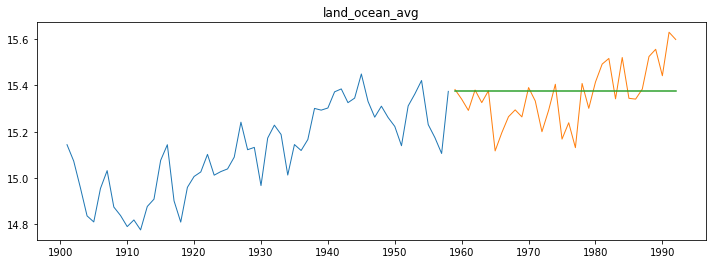

In [28]:
# plot actual and predicted values using loop
for col in train.columns:
    plot_and_eval(col)

In [36]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

Simple Average Model

In [42]:
loa = round(train['land_ocean_avg'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'land_ocean_avg':[loa]}, index=validate.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head()

,land_ocean_avg
date,
1958-12-31,15.11
1959-12-31,15.11
1960-12-31,15.11
1961-12-31,15.11
1962-12-31,15.11


land_ocean_avg -- RMSE : 0


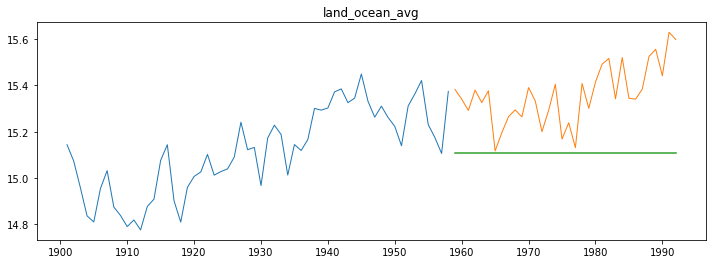

In [43]:
# plot actual vs predictions
for col in train.columns:
    plot_and_eval(col)

In [44]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', target_var = col)

Moving Average Model

In [46]:
# create a 10 year moving average model
# use the last 10 years to predict forwards

period = 10

loa = round(train['land_ocean_avg'].rolling(period).mean().iloc[-1],  2)

yhat_df = make_predictions()
yhat_df.head()

,land_ocean_avg
date,
1958-12-31,15.26
1959-12-31,15.26
1960-12-31,15.26
1961-12-31,15.26
1962-12-31,15.26


land_ocean_avg -- RMSE : 0


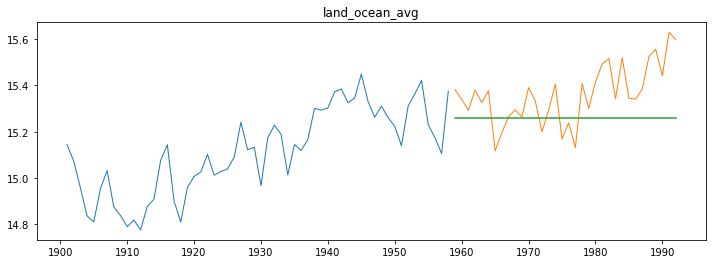

In [47]:
# plot actual vs predicted values
for col in train.columns:
    plot_and_eval(col)

In [48]:
# add to evaluation metrics
for col in train.columns:
    # this line was resampled in textbook example, but I resampled previously
    eval_df = append_eval_df(model_type='moving_average', target_var = col)

Holt's Linear Trend Model

land_ocean_avg 



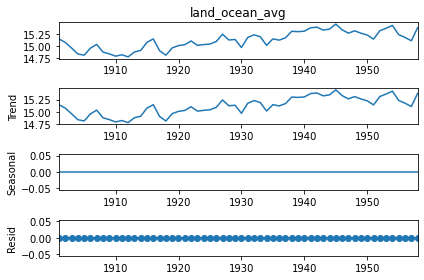

In [53]:
# look at the seasonal decomposition of the target
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col]).plot()
    plt.show()

In [55]:
# make predictions using Holt's method
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1, smoothing_slope=0.1, optimized=False)
    yhat_loa = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_loa, 2)

land_ocean_avg -- RMSE : 0


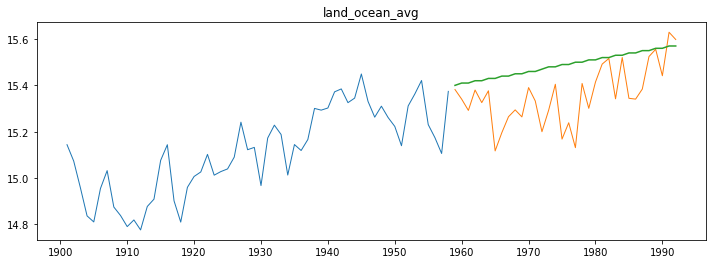

In [56]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(target_var = col)

In [57]:
# add to evaluation metrics
for col in train.columns:
    eval_df = append_eval_df(model_type='Holts', target_var = col)

Model Comparison

In [62]:
# get the rmse for each model
min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

# filter the rows to find only those the match the rmse
# to identify the best models
eval_df[((eval_df.rmse == min_rmse))]

,model_type,target_var,rmse
0,last_observed_value,land_ocean_avg,0.0
1,simple_average,land_ocean_avg,0.0
2,moving_average,land_ocean_avg,0.0
3,Holts,land_ocean_avg,0.0


Looking at the plots, the Holt model appears the best <br> <br>
Holt's on Test dataset

In [135]:
# make predictions using Holt's method
for col in train.columns:
    # model has already been fit and trained
    #model = Holt(train[col], exponential=False)
    #model = model.fit(smoothing_level=0.1, smoothing_slope=0.1, optimized=False)
    
    yhat_loa = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_loa, 2)

In [136]:
yhat_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 1958-12-31 to 1991-12-31
Freq: A-DEC
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   land_ocean_avg  34 non-null     float64
dtypes: float64(1)
memory usage: 544.0 bytes


land_ocean_avg -- RMSE : 0


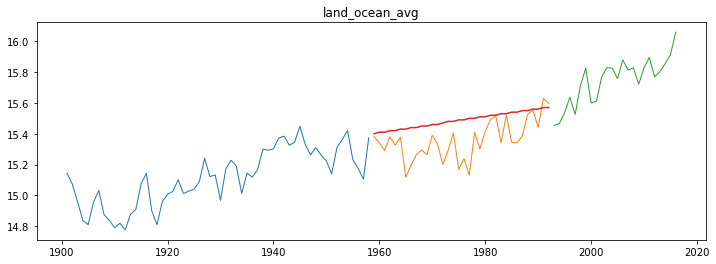

In [128]:
def plot_and_eval_test(target_var):
    plt.figure(figsize=(12, 4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE : {:.0f}'.format(rmse))
    plt.show()
    
# plot actual vs predicted
for col in train.columns:
    plot_and_eval_test(target_var = col)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

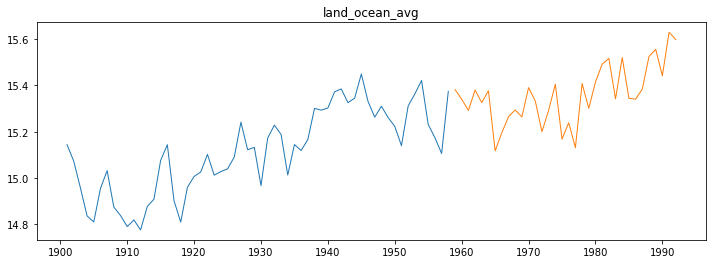

In [103]:
# plot actual vs predicted
for col in train.columns:
    plot_and_eval(target_var = col)

### Keep getting null values for yhat when forcasting with Holt's model <br>
- Still troublieshooting this error
- There are no null values in test dataset, but there are time gaps

# Conclusion <br>
- Temperature trends start an overall increase around 1920-1980
- Relatively high variation between years, possibly multi-year cyclic to some extent
- Holt's is the best model for predicting temperature trends

In [137]:
test.head()

,land_ocean_avg
date,
1992-12-31,15.453000
1993-12-31,15.466417
1994-12-31,15.535000
1995-12-31,15.637833
1996-12-31,15.524667


In [138]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24 entries, 1992-12-31 to 2015-12-31
Freq: A-DEC
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   land_ocean_avg  24 non-null     float64
dtypes: float64(1)
memory usage: 384.0 bytes
